In [1]:
!pip3 install fastf1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 13.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 19.0 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 22.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 40.5 MB/s eta 0:00:00


In [102]:
import fastf1 as ff1
from fastf1 import plotting
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import random  

plotting.setup_mpl()
ff1.Cache.enable_cache('../cache')

print('ENTER RACE DATA')
year = input('Enter year: ')
circuit = input('Enter circuit: ')
session = input('Sessions: FP1, FP2, FP3, Q, SQ(Sprint Qualifying), R(Race)\nEnter session: ')
num_drivers = int(input('Enter the number of drivers to analyze: '))

drivers = []
for i in range(num_drivers):
    driver = input('Enter 3-letter code of Driver {}: '.format(i+1))
    drivers.append(driver)

driver_colors = {
    driver: '#{:06x}'.format(random.randint(0, 0xFFFFFF))  
    for driver in drivers
}

year = int(year)

race = ff1.get_session(year, '{}'.format(circuit), '{}'.format(session))
race.load()
laps = race.laps

if laps is not None and not laps.empty:
    telemetry_data = []

    for driver in drivers:
        laps_driver = race.laps.pick_driver(driver)
        fastest_driver = laps_driver.pick_fastest().get_telemetry().add_distance()
        fastest_driver['Driver'] = driver
        telemetry_data.append(fastest_driver)
        
    telemetry = pd.concat(telemetry_data)
    cmap = cm.colors.ListedColormap(list(driver_colors.values()))
    num_minisectors = 25

    total_distance = max(telemetry['Distance'])

    minisector_length = total_distance / num_minisectors

    minisectors = [0]

    for i in range(0, (num_minisectors - 1)):
        minisectors.append(minisector_length * (i + 1))

    telemetry['Minisector'] = telemetry['Distance'].apply(
        lambda dist: (
            int((dist // minisector_length) + 1)
        )
    )
    average_speed = telemetry.groupby(['Minisector', 'Driver'])['Speed'].mean().reset_index()

    fastest_driver = average_speed.loc[average_speed.groupby(['Minisector'])['Speed'].idxmax()]

    fastest_driver = fastest_driver[['Minisector', 'Driver']].rename(columns={'Driver': 'Fastest_driver'})

    telemetry = telemetry.merge(fastest_driver, on=['Minisector'])

    telemetry = telemetry.sort_values(by=['Distance'])

    for i, driver in enumerate(drivers):
        telemetry.loc[telemetry['Fastest_driver'] == driver, 'Fastest_driver_int'] = i + 1

    x = np.array(telemetry['X'].values)
    y = np.array(telemetry['Y'].values)

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    fastest_driver_array = telemetry['Fastest_driver'].map(driver_colors).to_numpy()

    

ENTER RACE DATA


Enter year:  2021
Enter circuit:  Jeddah
Sessions: FP1, FP2, FP3, Q, SQ(Sprint Qualifying), R(Race)
Enter session:  R
Enter the number of drivers to analyze:  2
Enter 3-letter code of Driver 1:  VER
Enter 3-letter code of Driver 2:  HAM


core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.4.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '31', '3', '10', '16', '55', '99', '4', '18', '6', '14', '22', '7', '5', '11', '9', '63', '47']


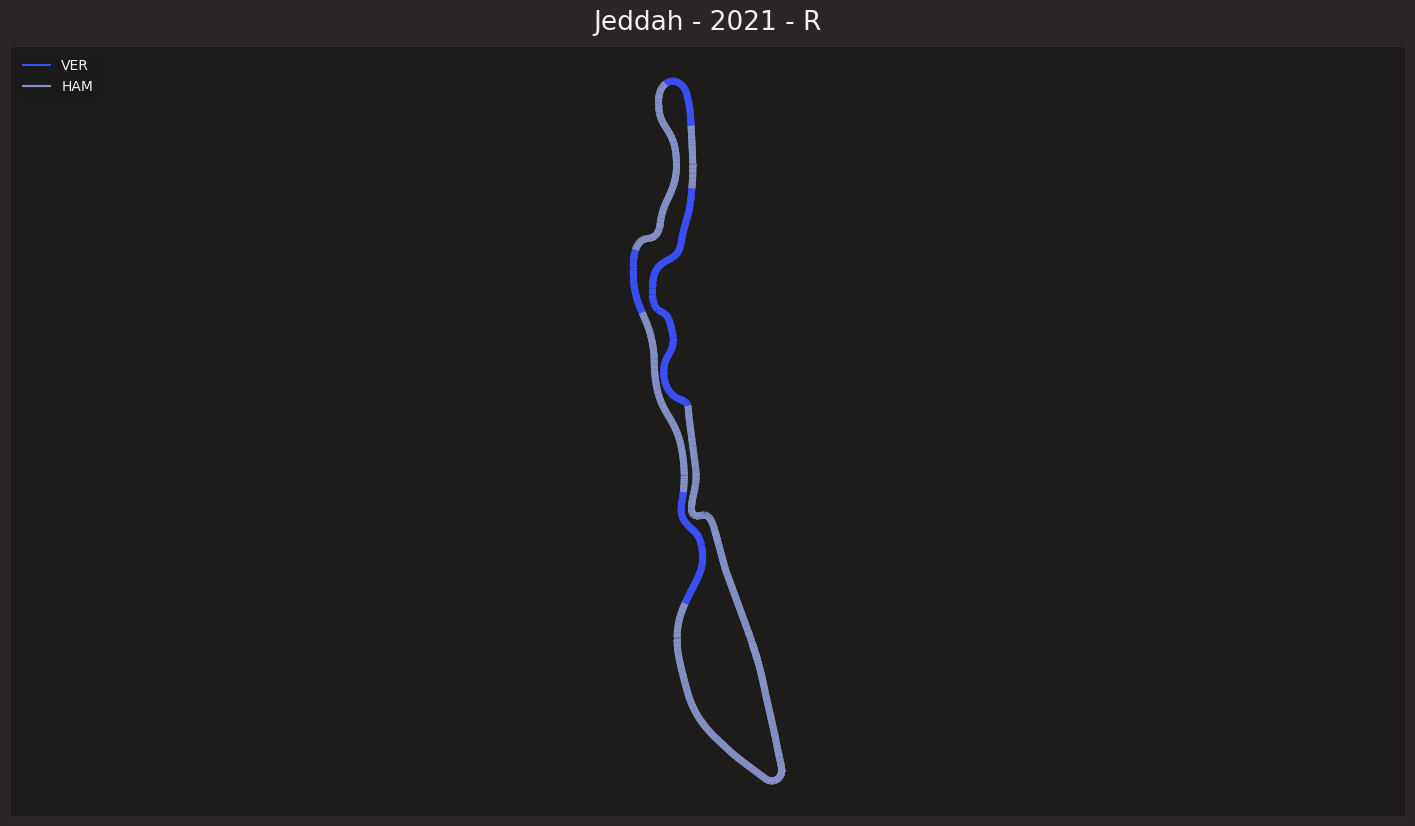

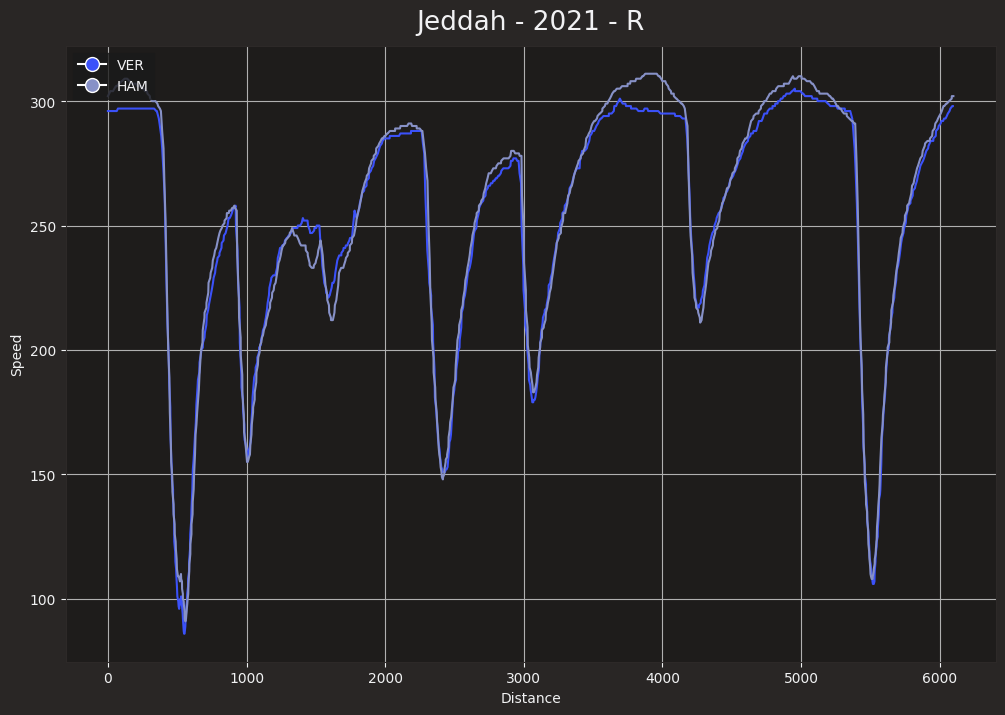

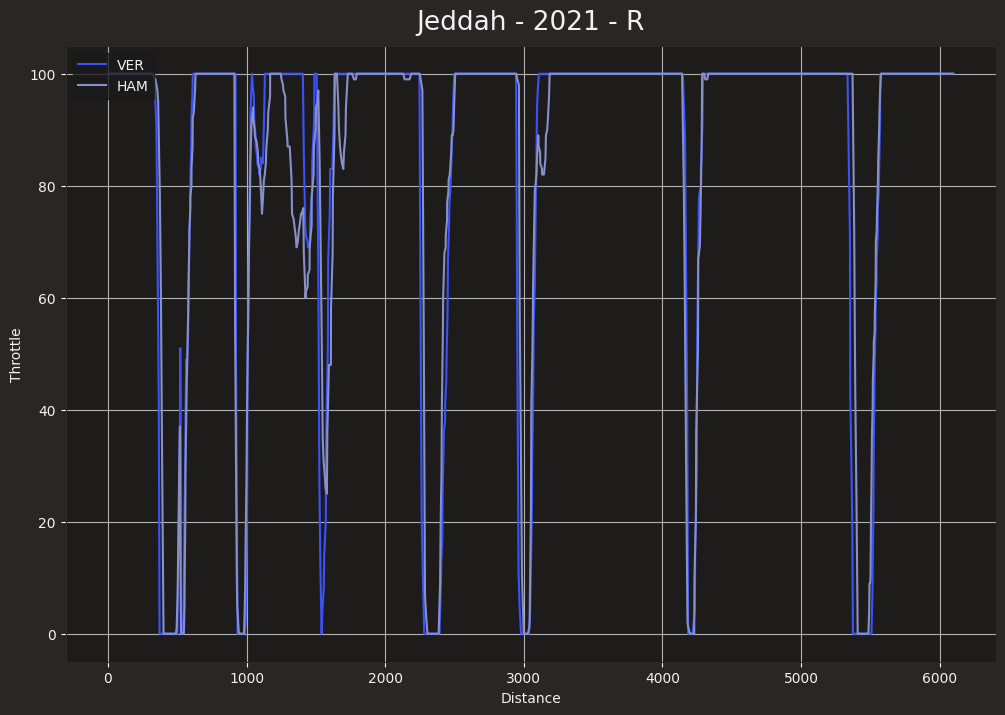

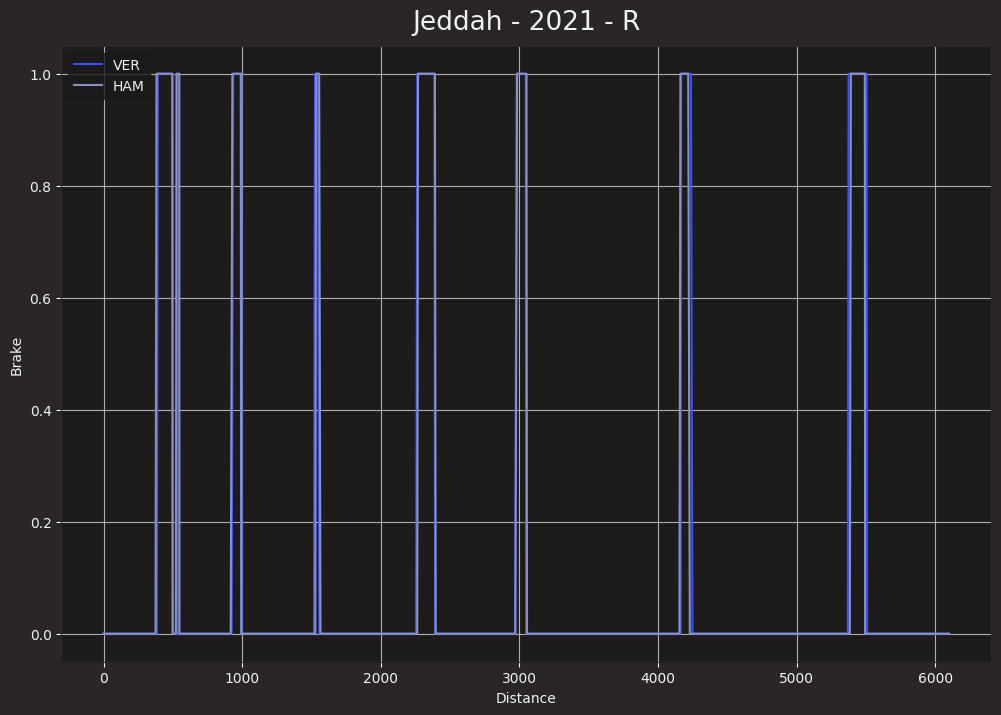

In [103]:

    lc_comp = LineCollection(segments, colors=fastest_driver_array, linewidths=5)
    c_cmap = mcolors.ListedColormap(list(driver_colors.values()))   
    plt.rcParams['figure.figsize'] = [18, 10]
    plt.gca().add_collection(lc_comp)
    plt.axis('equal')
    plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)

    
    plt.title('{} - {} - {}'.format(circuit,year,session))
    legend_elements = [Line2D([0], [0], color=color, label=driver) for driver, color in driver_colors.items()]
    plt.gca().add_collection(lc_comp)
    plt.axis('equal')
    plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
    plt.legend(handles=legend_elements, loc='upper left')  
    drivers = telemetry['Driver'].unique()
    
    plt.figure(figsize=(12, 8))
    for driver in drivers:
        driver_data = telemetry[telemetry['Driver'] == driver]
        plt.plot(driver_data['Distance'], driver_data['Speed'], label=driver, color=driver_colors[driver])

    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=driver, 
                               markerfacecolor=driver_colors[driver], markersize=10) 
                   for driver in drivers]
    plt.legend(handles=legend_elements, loc='upper left')
    plt.title('{} - {} - {}'.format(circuit,year,session))
    plt.xlabel('Distance')
    plt.ylabel('Speed')
    plt.grid(True)
    plt.savefig('driver_speed_graph.png', dpi=300)
plt.show()
    
    plt.figure(figsize=(12, 8))
    for driver in drivers:
        driver_data = telemetry[telemetry['Driver'] == driver]
        plt.plot(driver_data['Distance'], driver_data['Throttle'], label=driver, color=driver_colors[driver])
    plt.title('{} - {} - {}'.format(circuit,year,session))
    plt.xlabel('Distance')
    plt.ylabel('Throttle')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.savefig('driver_throttle_graph.png', dpi=300)
    plt.show()

    plt.figure(figsize=(12, 8))
    for driver in drivers:
        driver_data = telemetry[telemetry['Driver'] == driver]
        plt.plot(driver_data['Distance'], driver_data['Brake'], label=driver, color=driver_colors[driver])
    plt.title('{} - {} - {}'.format(circuit,year,session))
    plt.xlabel('Distance')
    plt.ylabel('Brake')
    plt.grid(True)
plt.legend(loc='upper left')
    plt.savefig('driver_brake_graph.png', dpi=300)
    plt.show()

